# Predicting Risk of Heart Disease Based on Medical History

In [1]:
#run these cells to start

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
data <- read_csv("https://raw.githubusercontent.com/LordofSabres/Team_Pineapples_DSCI_100/main/heart_cleveland_upload.csv") |>
mutate(condition = as.factor(condition))
data

ERROR: Error in mutate(read_csv("https://raw.githubusercontent.com/LordofSabres/Team_Pineapples_DSCI_100/main/heart_cleveland_upload.csv"), : could not find function "mutate"


In [4]:
data_filter <- data |>
select(age, cp, trestbps, chol, fbs, restecg, condition)
data_filter
data_slice <- data_filter |>
slice_sample(prop=0.5)
data_slice
data_split <- data_slice |>
initial_split(prop = 0.5, strata = condition)
data_train <- training(data_split)
data_testing <- testing(data_split)
data_train
data_testing



age,cp,trestbps,chol,fbs,restecg,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69,0,160,234,1,2,0
69,0,140,239,0,0,0
66,0,150,226,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,3,120,198,0,0,1
35,3,138,183,0,0,0
35,3,126,282,0,2,1


age,cp,trestbps,chol,fbs,restecg,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62,1,128,208,1,2,0
68,2,118,277,0,0,0
52,2,136,196,0,2,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,112,160,0,0,0
44,2,120,226,0,0,0
63,0,145,233,1,2,0


age,cp,trestbps,chol,fbs,restecg,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,2,136,196,0,2,0
76,2,140,197,0,1,0
64,3,128,263,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,3,132,184,0,2,1
46,3,140,311,0,0,1
53,3,123,282,0,0,1


age,cp,trestbps,chol,fbs,restecg,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
62,1,128,208,1,2,0
68,2,118,277,0,0,0
52,3,112,230,0,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,3,120,267,0,0,1
44,2,120,226,0,0,0
63,0,145,233,1,2,0


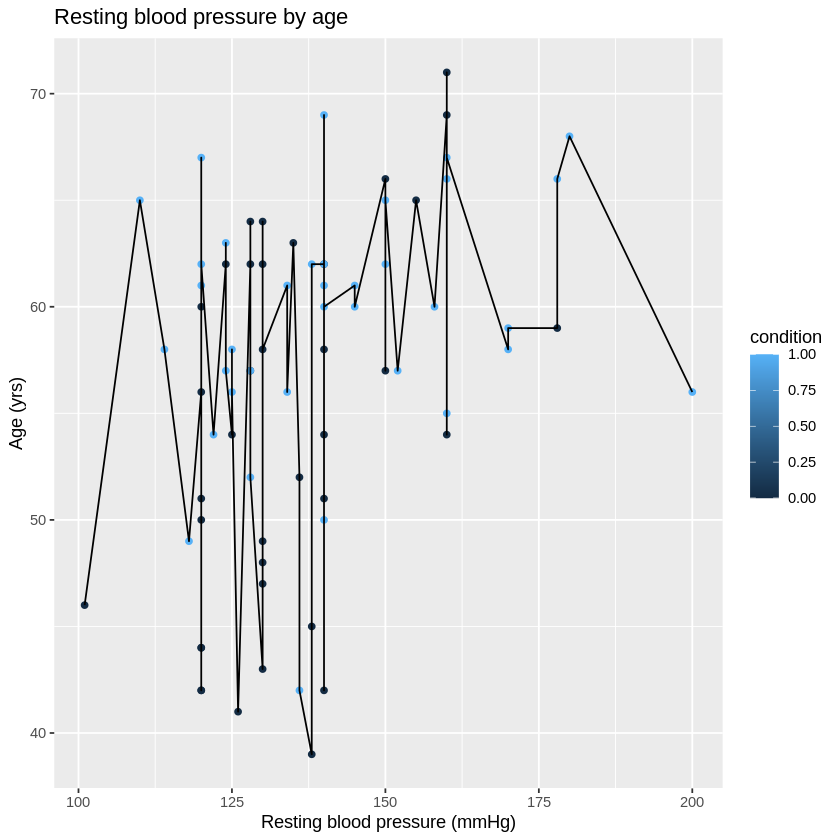

In [19]:
training_plot <- ggplot(data_train, aes(x=trestbps, y=age)) +
    geom_point(aes(colour=condition)) +
    geom_line() +
    ggtitle("Resting blood pressure by age") +
    labs(x = "Resting blood pressure (mmHg)", y = "Age (yrs)")

training_plot

### INTRODUCTION

"Heart disease" is a catchall term used to describe a variety of conditions affecting the heart or blood vessels. As the heart is responsible for the proper circulation of blood throughout the body, diseases of the heart can have lifelong and potentially fatal consequences, such as heart attacks, heart failure, or strokes. Many factors play a role in an individual’s heart health, from chosen behaviours such as diet, level of exercise or smoking, to genetic variables such as blood pressure and heart rate.  Knowing the influence that medical history has on the risk of heart disease, we aim to create a model that can predict whether a patient has heart disease based on their unique medical history, looking specifically at how cholesterol levels, fasting blood sugar, chest pain, blood pressure, and heart rate could act as potential predictors. 

The question we aim to answer through the creation of the model is “Can we predict whether or not a patient will be at risk of heart disease based on existing medical history?”. 

The dataset we will be using to answer this question is the Cleveland Heart Disease database. This database was donated and completed on June 30th, 1988 from the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. It consists of a total of 76 variables relating to heart disease patients, but for our purposes we will be summarizing it to our 6 chosen predictor variables. 

### METHODS

ADD HERE

### Expected outcomes and Significance

All of the variables we selected (age, sex, cholesterol, fasting blood sugar, chest pain, resting ecg, resting blood pressure) are positively correlated with the likelihood of an individual having heart disease. 